In [13]:
import os
import yaml
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [14]:
year_range_maps = {
    # v2
    "era5_weekly_aurora_2000-2022-wb13-1h-240x121.zarr-v2": (2000, 2022),
    "era5_weekly_aurora_2010-2022-wb13-1h-240x121.zarr-v2": (2010, 2022),
    "era5_weekly_aurora_2020-2022-wb13-1h-240x121.zarr-v2": (2020, 2022),
    "era5_6h_aurora_2020-2022-wb13-6h-1440x721.zarr-v2": (2020, 2022),
    # v3
    "era5_weekly_aurora_2000-2022-wb13-1h-240x121.zarr-v3": (2000, 2022),
    "era5_weekly_aurora_2010-2022-wb13-1h-240x121.zarr-v3": (2010, 2022),
    "era5_weekly_aurora_2020-2022-wb13-1h-240x121.zarr-v3": (2020, 2022),
    "era5_6h_aurora_2020-2022-wb13-6h-1440x721.zarr-v3": (2020, 2022),
}

def parse_experiment(exp_dir):
    args_path = os.path.join(exp_dir, "args.yaml")
    times_summary_path = os.path.join(exp_dir, "times_summary.yaml")
    
    # get date as datetime
    try:
        date_str = os.path.basename(exp_dir).split("-")[1]
    except Exception as e:
        print(f"Error parsing date from {exp_dir}: {e}")
        return {}
    date = datetime.datetime.strptime(date_str, "%Y%m%dT%H%M%S")
    
    # Check if the required files exist
    if not os.path.exists(args_path):
        print(f"Warning: {args_path} does not exist. Experiment might not be complete.")
        return {}
    if not os.path.exists(times_summary_path):
        print(f"Warning: {times_summary_path} does not exist. Experiment might not be complete.")
        return {}
    
    # read args.yaml
    with open(os.path.join(exp_dir, "args.yaml"), "r") as f:
        args = yaml.safe_load(f)
    zarr_format = args.get("zarr_format", None)
    dataset = args.get("dataset", None)
    if os.path.exists(dataset): 
        source = "local"
        year_range = year_range_maps[os.path.basename(dataset)]
    else: 
        source = "gcs"
        date_range = args.get("date_range", None)
        year_range = (int(date_range[0].split("-")[0]), int(date_range[1].split("-")[0]))
    
    # read times_summary.yaml
    with open(os.path.join(exp_dir, "times_summary.yaml"), "r") as f:
        times_summary = yaml.safe_load(f)
    times = times_summary.get("times", None)
    
    return {
        "date": date,
        "zarr_format": zarr_format,
        "dataset": dataset,
        "source": source,
        "year_range": "-".join([str(y) for y in year_range]),
        "times": times,
        "id": "-".join([str(y) for y in year_range]) + f"\n{source}\nzarr-v{zarr_format}",
    }
    
def experiment_dir_to_df(experiment_dir):
    experiment_data = []
    for exp_dir in os.listdir(experiment_dir):
        exp_path = os.path.join(experiment_dir, exp_dir)
        print(f"Processing: {exp_path}")
        if not os.path.isdir(exp_path):
            continue
        
        # Parse the experiment directory
        data = parse_experiment(exp_path)
        if not data:
            continue
        experiment_data.append(data)

    experiment_df = pd.DataFrame(experiment_data).sort_values(by=["year_range"], ascending=False)
    return experiment_df

def boxplot(df, ax, title):
    ax.boxplot(
        [times for times in df.times.values],
        tick_labels=[id_ for id_ in df.id.values],
        showfliers=False,
        patch_artist=True,
    )
    ax.set_title(title)
    ax.set_ylabel("Batch loading time (s)")
    return ax   

Processing: ./experiments/1w_240x121/jade_door-20250514T170859
Processing: ./experiments/1w_240x121/field_drought-20250514T172212
Processing: ./experiments/1w_240x121/violet_stag-20250514T170859
Processing: ./experiments/1w_240x121/beryl_horn-20250514T170859
Processing: ./experiments/1w_240x121/mountain_thunder-20250514T170900
Processing: ./experiments/1w_240x121/nacre_sloth-20250514T170900
Processing: ./experiments/1w_240x121/obsidian_major-20250514T170859


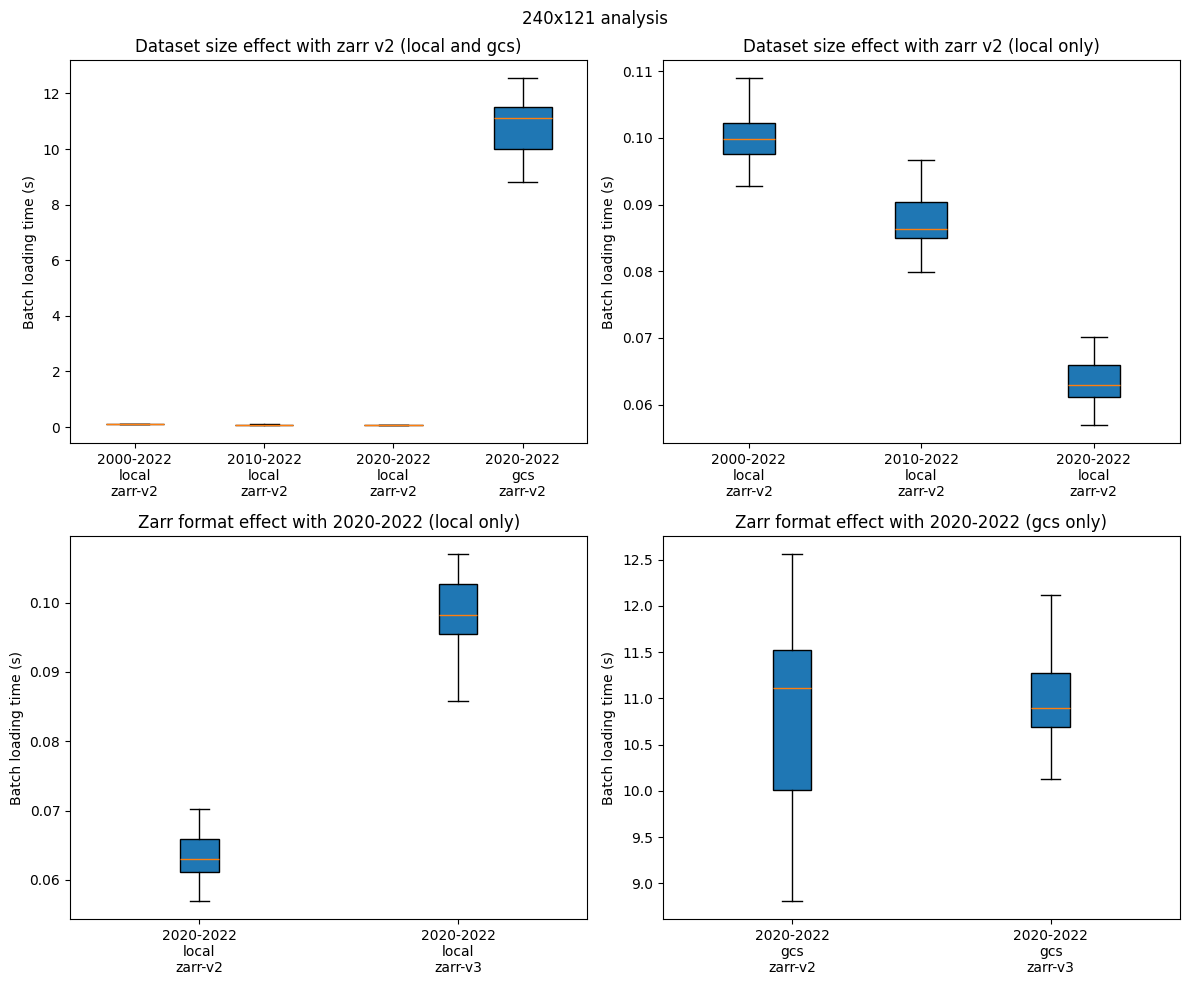

In [15]:
experiment_dir = "./experiments/1w_240x121"
experiment_df = experiment_dir_to_df(experiment_dir)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

boxplot(
    experiment_df.query("zarr_format == 2").sort_values(by=["year_range"]),
    axs[0, 0],
    "Dataset size effect with zarr v2 (local and gcs)"
)
boxplot(
    experiment_df.query("zarr_format == 2 & source == 'local'").sort_values(by=["year_range"]),
    axs[0, 1],
    "Dataset size effect with zarr v2 (local only)"
)
boxplot(
    experiment_df.query("year_range == '2020-2022' & source == 'local'").sort_values(by=["zarr_format"]),
    axs[1, 0],
    "Zarr format effect with 2020-2022 (local only)"
)
boxplot(
    experiment_df.query("year_range == '2020-2022' & source == 'gcs'").sort_values(by=["zarr_format"]),
    axs[1, 1],
    "Zarr format effect with 2020-2022 (gcs only)"
)

fig.suptitle("240x121 analysis")
fig.tight_layout()
fig.show()

Processing: ./experiments/6h_1440x721/revealing_keyboard-20250514T170335
Processing: ./experiments/6h_1440x721/emerald_weapon-20250514T170413


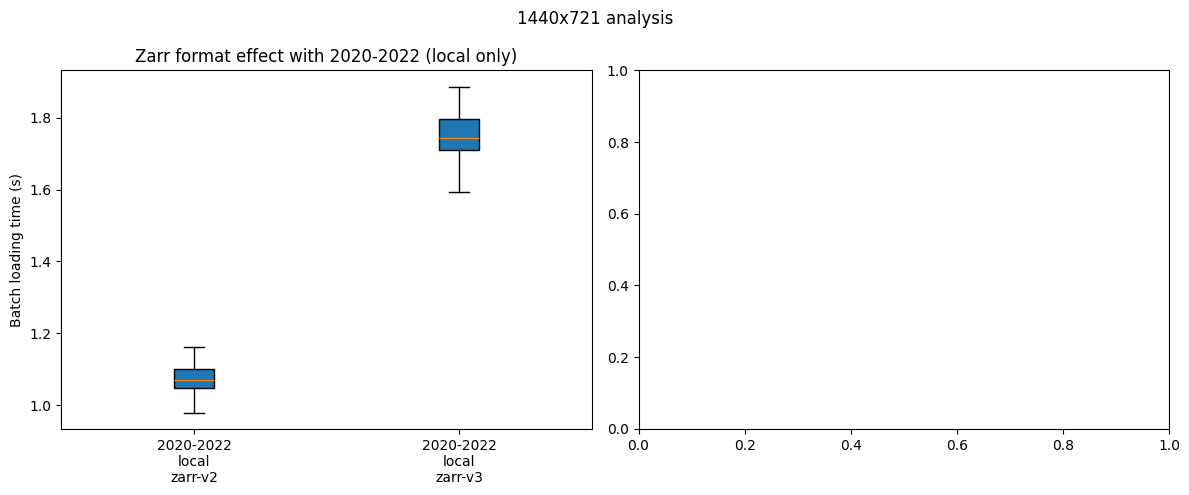

In [12]:
experiment_dir = "./experiments/6h_1440x721"
experiment_df = experiment_dir_to_df(experiment_dir)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

boxplot(
    experiment_df.query("year_range == '2020-2022' & source == 'local'").sort_values(by=["zarr_format"]),
    axs[0],
    "Zarr format effect with 2020-2022 (local only)"
)
if not experiment_df.query("year_range == '2020-2022' & source == 'gcs'").empty:
    boxplot(
        experiment_df.query("year_range == '2020-2022' & source == 'gcs'").sort_values(by=["zarr_format"]),
        axs[1],
        "Zarr format effect with 2020-2022 (gcs only)"
    )

fig.suptitle("1440x721 analysis")
fig.tight_layout()
fig.show()

## 